In [30]:
import pandas as pd
from scipy.linalg import svd
import numpy as np
import random
import time
start_time = time.time()

### 读取数据并进行预处理

In [31]:
def data_preprocess(path:str):
    """
    读取数据并进行预处理
    :param path: 数据路径
    :return: 数据矩阵，行索引，列索引
    """
    data = pd.read_csv(path, index_col=0)
    return data.values, data.index, data.columns

In [32]:
data_raw, _, _ = data_preprocess('svd-raw-data.csv')
data_raw

array([[5. , 5. , 5. , 4.5, 5. , 5. , 4.5, 4.5, 4.5, 4.5],
       [4.5, 5. , 4. , 4.5, 4.5, 4. , 3.5, 4.5, 4.5, 4.5],
       [4. , 3.5, 4.5, 2.5, 4. , 4. , 2.5, 3.5, 4.5, 3. ],
       [3.5, 3.5, 3. , 4. , 4. , 4. , 3.5, 4. , 3.5, 3.5],
       [4.5, 4.5, 5. , 4. , 4. , 3. , 3.5, 4.5, 4.5, 4. ],
       [5. , 5. , 5. , 5. , 3. , 5. , 2. , 5. , 4. , 5. ],
       [5. , 4. , 5. , 4. , 4. , 5. , 4. , 5. , 5. , 5. ],
       [5. , 5. , 5. , 3. , 5. , 5. , 2. , 5. , 4. , 5. ],
       [5. , 5. , 5. , 4. , 5. , 5. , 4. , 5. , 5. , 4. ],
       [5. , 5. , 4. , 4. , 3.5, 3. , 3.5, 4. , 3.5, 4. ]])

### 划分验证集和训练集

In [33]:
def spilt_train_valid(data:np.ndarray):
    """
    将数据集划分为训练集和验证集
    :param data: 数据集
    :return: 训练集，验证集，训练集索引，验证集索引
    """
    row, col = data.shape
    indices = indices = [(i,j) for i in range(row) for j in range(col)]
    random.seed(100)
    # 随机取三十个索引作为验证集
    random_list = random.sample(range(0, len(indices)), int(len(indices)*0.3))

    valid_indices = [indices[i] for i in random_list]   
    train_indices = list(set(indices) - set(valid_indices)) 
    valid_indices = np.array(valid_indices).T[0], np.array(valid_indices).T[1]  # 验证集索引
    train_indices = np.array(train_indices).T[0], np.array(train_indices).T[1]  # 训练集索引
    train = data.copy()
    train[valid_indices] = 0    # 训练集
    valid = data.copy()
    valid[train_indices] = 0    # 验证集
    return train, valid, train_indices, valid_indices

In [34]:
train_matrix, valid_matrix, train_indices, valid_indices = spilt_train_valid(data_raw)
train_matrix, valid_matrix, train_indices, valid_indices

(array([[5. , 5. , 5. , 4.5, 5. , 5. , 0. , 4.5, 4.5, 4.5],
        [0. , 5. , 4. , 4.5, 0. , 0. , 3.5, 4.5, 0. , 4.5],
        [4. , 3.5, 0. , 2.5, 0. , 4. , 0. , 3.5, 4.5, 0. ],
        [3.5, 3.5, 3. , 0. , 4. , 4. , 3.5, 4. , 3.5, 0. ],
        [4.5, 4.5, 0. , 4. , 0. , 3. , 3.5, 0. , 4.5, 4. ],
        [0. , 5. , 0. , 5. , 3. , 0. , 2. , 5. , 0. , 5. ],
        [5. , 4. , 5. , 4. , 0. , 5. , 4. , 5. , 0. , 5. ],
        [5. , 5. , 5. , 3. , 5. , 5. , 2. , 0. , 4. , 5. ],
        [5. , 0. , 0. , 4. , 5. , 5. , 4. , 5. , 5. , 4. ],
        [0. , 5. , 0. , 0. , 3.5, 3. , 0. , 0. , 0. , 0. ]]),
 array([[0. , 0. , 0. , 0. , 0. , 0. , 4.5, 0. , 0. , 0. ],
        [4.5, 0. , 0. , 0. , 4.5, 4. , 0. , 0. , 4.5, 0. ],
        [0. , 0. , 4.5, 0. , 4. , 0. , 2.5, 0. , 0. , 3. ],
        [0. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 3.5],
        [0. , 0. , 5. , 0. , 4. , 0. , 0. , 4.5, 0. , 0. ],
        [5. , 0. , 5. , 0. , 0. , 5. , 0. , 0. , 4. , 0. ],
        [0. , 0. , 0. , 0. , 4. , 0. ,

### 将平均值填入训练集的空值部分

In [35]:
def normalize(train_matrix:np.ndarray)->np.ndarray:
    """
    对训练集中的空值进行处理，填入用户评分均值
    :param train_matrix: 训练集
    :return: 处理后的训练集
    """
    row, col = train_matrix.shape
    mean = np.sum(train_matrix, axis=1) / np.sum(train_matrix != 0, axis=1)
    mean = mean.reshape(row, 1)
    # 将空值替换为该行的平均值
    train_matrix = np.where(train_matrix == 0, mean, train_matrix)
    return train_matrix

In [36]:
train_matrix= normalize(train_matrix)
train_matrix

array([[5.        , 5.        , 5.        , 4.5       , 5.        ,
        5.        , 4.77777778, 4.5       , 4.5       , 4.5       ],
       [4.33333333, 5.        , 4.        , 4.5       , 4.33333333,
        4.33333333, 3.5       , 4.5       , 4.33333333, 4.5       ],
       [4.        , 3.5       , 3.66666667, 2.5       , 3.66666667,
        4.        , 3.66666667, 3.5       , 4.5       , 3.66666667],
       [3.5       , 3.5       , 3.        , 3.625     , 4.        ,
        4.        , 3.5       , 4.        , 3.5       , 3.625     ],
       [4.5       , 4.5       , 4.        , 4.        , 4.        ,
        3.        , 3.5       , 4.        , 4.5       , 4.        ],
       [4.16666667, 5.        , 4.16666667, 5.        , 3.        ,
        4.16666667, 2.        , 5.        , 4.16666667, 5.        ],
       [5.        , 4.        , 5.        , 4.        , 4.625     ,
        5.        , 4.        , 5.        , 4.625     , 5.        ],
       [5.        , 5.        , 5.       

### SVD分解，保留部分特征值并还原

In [37]:
def SVD(train_mat:np.ndarray, k:int)->np.ndarray:
    """
    使用SVD对训练集进行分解，保留部分特征值，并预测
    :param train_mat: 训练集
    :param k: 保留的特征值数量
    :return: 还原后的矩阵
    """
    U, sigma, VT = svd(train_mat)
    sigma = np.diag(sigma[:k])  # 保留前k个特征值
    predict_mat = U[:, :k].dot(sigma).dot(VT[:k, :]) # 还原矩阵
    return predict_mat

In [38]:
predict_matrix = SVD(train_matrix, k=3)
predict_matrix

array([[5.03361431, 4.88473341, 4.72651527, 4.27623309, 4.97959336,
        4.7890814 , 4.65812553, 4.80548685, 4.99669462, 4.57918187],
       [4.47972269, 4.87503946, 4.28097577, 4.39910078, 4.09928666,
        4.15384148, 3.53427544, 4.59258754, 4.40803829, 4.5052753 ],
       [3.99157775, 3.47688965, 3.75164219, 2.82799861, 4.13870444,
        3.97635572, 3.65057575, 3.58737015, 3.85943136, 3.44163675],
       [3.79774139, 3.76749788, 3.57090481, 3.33182174, 3.71204889,
        3.58541856, 3.47614115, 3.67316151, 3.77876082, 3.50667183],
       [4.08774952, 4.46508538, 3.8499377 , 4.14831594, 3.7891127 ,
        3.69096868, 3.70150714, 4.18680173, 4.15135554, 3.99289732],
       [4.23128926, 5.35556128, 4.20806647, 4.88460831, 3.34053089,
        3.86487889, 1.9760549 , 4.80107491, 3.97892051, 4.99799526],
       [5.00201569, 4.68732632, 4.78843152, 3.83583328, 4.937859  ,
        4.98121336, 3.85131606, 4.70270078, 4.72256592, 4.672486  ],
       [4.92774638, 4.50133688, 4.9285687

### MAE & RMSE

In [39]:
def MAE(valid_mat, predict_mat, valid_indices):
    temp = valid_mat[valid_indices] - predict_mat[valid_indices]
    return np.mean(np.abs(temp))

In [40]:
def RMSE(valid_mat, predict_mat, valid_indices):
    temp = valid_mat[valid_indices] - predict_mat[valid_indices]
    return np.sqrt(np.mean(temp ** 2))

In [16]:
# MAE(train_matrix, predict_matrix, train_indices), RMSE(train_matrix, predict_matrix, train_indices)

(0.21235349144597607, 0.2794083444700769)

In [17]:
# predict_matrix[train_indices] = train_matrix[train_indices]
# predict_matrix = SVD(predict_matrix, k=3)
# MAE(train_matrix, predict_matrix, train_indices), RMSE(train_matrix, predict_matrix, train_indices)

(0.19414459329313868, 0.2508810377113763)

### 训练

In [72]:
def train(train_matrix:np.ndarray, train_indices, k:int, epoch:int=200, log:bool=True)->tuple[np.ndarray, float, float]:
    """
    训练
    :params train_matrix: 训练集
    :params train_indices: 训练集索引
    :params k: 保留的特征值数量
    :params epoch: 迭代次数
    :params log: 是否打印日志
    :return 预测矩阵
    """
    train_matrix_ori = train_matrix.copy()
    for i in range(epoch):
        train_matrix = SVD(train_mat=train_matrix, k=k)
        if log:
            print(f"epoch: {i+1}\tMAE: {MAE(train_matrix_ori, train_matrix, train_indices)}")
        train_matrix[train_indices] = train_matrix_ori[train_indices]        
    return train_matrix

In [73]:
pred_mat= train(train_matrix, train_indices, k=3, epoch=200)
pred_mat

epoch: 1	MAE: 0.21235349144597607
epoch: 2	MAE: 0.19414459329313868
epoch: 3	MAE: 0.18415855915897764
epoch: 4	MAE: 0.17840898452339005
epoch: 5	MAE: 0.17482802361369537
epoch: 6	MAE: 0.1722039207680848
epoch: 7	MAE: 0.1698983411605974
epoch: 8	MAE: 0.16782354364283003
epoch: 9	MAE: 0.16608963494831241
epoch: 10	MAE: 0.16457445107775695
epoch: 11	MAE: 0.1632955118402983
epoch: 12	MAE: 0.16225733964225345
epoch: 13	MAE: 0.16135774372199943
epoch: 14	MAE: 0.1605325795574629
epoch: 15	MAE: 0.159775344660985
epoch: 16	MAE: 0.15907947062840405
epoch: 17	MAE: 0.15843849454106648
epoch: 18	MAE: 0.15784614250873247
epoch: 19	MAE: 0.15729637834898
epoch: 20	MAE: 0.1567834394047729
epoch: 21	MAE: 0.15630186807906438
epoch: 22	MAE: 0.1558465422793059
epoch: 23	MAE: 0.15541270586574293
epoch: 24	MAE: 0.15499599923952867
epoch: 25	MAE: 0.15459248953538962
epoch: 26	MAE: 0.15419869924196464
epoch: 27	MAE: 0.15381163146091145
epoch: 28	MAE: 0.15342878953021744
epoch: 29	MAE: 0.1530481884937706
epoch:

array([[5.        , 5.        , 5.        , 4.5       , 5.        ,
        5.        , 3.38076626, 4.5       , 4.5       , 4.5       ],
       [4.77815366, 5.        , 4.        , 4.5       , 3.49192348,
        3.0804319 , 3.5       , 4.5       , 4.79847004, 4.5       ],
       [4.        , 3.5       , 2.40761347, 2.5       , 4.39193926,
        4.        , 6.18488494, 3.5       , 4.5       , 2.04593006],
       [3.5       , 3.5       , 3.        , 2.64084966, 4.        ,
        4.        , 3.5       , 4.        , 3.5       , 2.99901648],
       [4.5       , 4.5       , 3.75464533, 4.        , 3.43509021,
        3.        , 3.5       , 4.31693774, 4.5       , 4.        ],
       [4.84196609, 5.        , 4.58861093, 5.        , 3.        ,
        2.64102437, 2.        , 5.        , 4.54489243, 5.        ],
       [5.        , 4.        , 5.        , 4.        , 5.18460083,
        5.        , 4.        , 5.        , 4.71719566, 5.        ],
       [5.        , 5.        , 5.       

# 完整流程

In [70]:
import matplotlib.pyplot as plt 
def MF(data_path, k:int, epoch:int):
    """
    矩阵分解
    :params data_path: 数据路径
    :params k: 保留的特征值数量
    :params epoch: 迭代次数
    """
    # 数据预处理
    data_raw, user, movie = data_preprocess(path=data_path)
    # 划分训练集，验证集
    train_matrix, valid_matrix, train_indices, valid_indices = spilt_train_valid(data_raw)
    # 将训练集的空值部分填入用户评分均值
    train_matrix = normalize(train_matrix)
    # 训练
    predict_matrix = train(train_matrix, train_indices, k=k, epoch=epoch, log=True)

    mae = MAE(valid_matrix, predict_matrix, valid_indices)
    rmse = RMSE(valid_matrix, predict_matrix, valid_indices)

    plt.bar(["MAE","RMSE"], [mae, rmse])
    plt.title("evaluation")

    pd.DataFrame(predict_matrix, index=user, columns=movie).to_csv("svd-predict-rating.csv")
    
    return predict_matrix

epoch: 1	MAE: 0.21235349144597607
epoch: 2	MAE: 0.19414459329313868
epoch: 3	MAE: 0.18415855915897764
epoch: 4	MAE: 0.17840898452339005
epoch: 5	MAE: 0.17482802361369537
epoch: 6	MAE: 0.1722039207680848
epoch: 7	MAE: 0.1698983411605974
epoch: 8	MAE: 0.16782354364283003
epoch: 9	MAE: 0.16608963494831241
epoch: 10	MAE: 0.16457445107775695
epoch: 11	MAE: 0.1632955118402983
epoch: 12	MAE: 0.16225733964225345
epoch: 13	MAE: 0.16135774372199943
epoch: 14	MAE: 0.1605325795574629
epoch: 15	MAE: 0.159775344660985
epoch: 16	MAE: 0.15907947062840405
epoch: 17	MAE: 0.15843849454106648
epoch: 18	MAE: 0.15784614250873247
epoch: 19	MAE: 0.15729637834898
epoch: 20	MAE: 0.1567834394047729
epoch: 21	MAE: 0.15630186807906438
epoch: 22	MAE: 0.1558465422793059
epoch: 23	MAE: 0.15541270586574293
epoch: 24	MAE: 0.15499599923952867
epoch: 25	MAE: 0.15459248953538962
epoch: 26	MAE: 0.15419869924196464
epoch: 27	MAE: 0.15381163146091145
epoch: 28	MAE: 0.15342878953021744
epoch: 29	MAE: 0.1530481884937706
epoch:

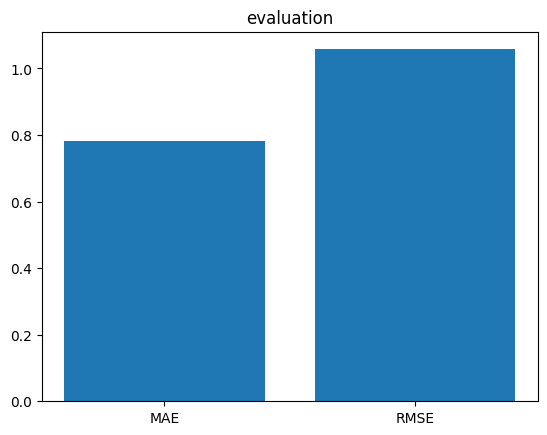

In [71]:
pred_mat = MF('svd-raw-data.csv', k=3, epoch=100)

In [145]:
print(f"运行时间：{time.time() - start_time}s")

运行时间：1.0842437744140625s


In [146]:
# train_matrix = np.array([[4,3,0,0,0,4],
#                          [4,1,3,0,4,4],
#                          [0,1,3,4,2,5],
#                          [3,0,3,0,4,4],
#                          [3,4,3,0,3,3],
#                          [4,0,3,5,3,4]])
# train_indices = np.where(train_matrix != 0)
# valid_indices = np.where(train_matrix == 0)
# train_matrix = normalize(train_matrix)

In [147]:
# pred = SVD(train_matrix, k=3)

In [148]:
# MAE(train_matrix, pred, train_indices), RMSE(train_matrix, pred, train_indices)

In [149]:
# _ = train(train_matrix, train_indices, k=3, epoch=200)